## &beta;-VAE - gradually increase 'capacity'

### Information bottleneck perspective

- The $\beta$-VAE objective is closely related to the information bottleneck principle:
$$\max[\mathit{I(Z;Y)} - \beta\mathit{I(X;Z)}]$$
- The information bottleneck describes a constrained optimisation objective where the goal is to maximise the mutual information between the latent bottleneck Z and the task Y while discarding all the irrelevant information about Y that might be present in the input X.  <br>
*source: [Understanding disentangling in β-VAE](https://arxiv.org/abs/1804.03599)

### The new objective

$$L_\text(\phi, \beta) = - \mathbb{E}_{q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) + \gamma | D_\text{KL}(q_\phi(\mathbf{z}\vert\mathbf{x})\|p_\theta(\mathbf{z})) - C |$$
- C is gradually increased from zero to a value large enough to produce good quality reconstructions. 
    - In the paper, C was increased to 50 for CelebA. $ C = C_{max} * iter/10^5$

### Intuitions

- In the dSprites dataset (consisting of white 2D sprites varying in position, rotation, scale and shape, the model might only encode the sprite position under a strong IB constraint. Intuitively, when optimising a pixel-wise decoder log likelihood, information about position will result in the most gains.
    - Transmission bandwidth가 강하게 제한되어 있다면 reconstruction에 가장 많은 도움이 될 bit를 먼저 전달하기 시작
- Continuing this intuitive picture, we can imagine that if the capacity of the information bottleneck were gradually increased, the model would continue to utilise those extra bits for an increasingly precise encoding of position, until some point of diminishing returns is reached for position information, where a larger improvement can be obtained by encoding and reconstructing another factor of variation in the dataset, such as sprite scale.
    - IB capacity를 조금씩 열어주면 그 position을 통한 gain이 줄어들면서 그 다음 중요한 factor를 전달하기 시작

In [1]:
%matplotlib inline

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device("cuda:1")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import copy

In [3]:
lr = 0.0005
z_dim = 64
gamma = 1000
capacity_limit = 200
capacity_change_duration = 1e5

In [4]:
def calc_encoding_capacity(step):
    if step > capacity_change_duration:
        c = capacity_limit
    else:
        c = capacity_limit * (step / capacity_change_duration)
    return c

In [5]:
class CelebaDataset(Dataset):

    def __init__(self, root_dir, im_name_list, resize_dim, transform=None):
        self.root_dir = root_dir
        self.im_list = im_name_list
        self.resize_dim = resize_dim
        self.transform = transform

    def __len__(self):
        return len(self.im_list)

    def __getitem__(self, idx):
        im = Image.open(os.path.join(self.root_dir, self.im_list[idx]))        

        if self.transform:
            im = self.transform(im)

        return im

In [6]:
root_dir = "../../VAE/img_align_celeba/"
image_files = os.listdir(root_dir)
print(image_files[0])

071051.jpg


In [7]:
trans = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

train_dataset = CelebaDataset(root_dir, image_files[:190000], (64, 64), transform=trans)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

valid_dataset = CelebaDataset(root_dir, image_files[190000:200000], (64, 64), transform=trans)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [8]:
for x,y in enumerate(train_loader):
    print(np.shape(y))
    break

torch.Size([64, 3, 64, 64])


In [9]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), padding=1, stride=1, pool_kernel_size=(2, 2)):
        super(Conv_Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding, stride)
        self.pool = nn.MaxPool2d(pool_kernel_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        return x

In [10]:
class Encoder(nn.Module):
    """ 
    outputs are the mean, std of the latent variable z.
    """
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.block1 = Conv_Block(3, 64)
        self.block2 = Conv_Block(64, 128)  
        self.block3 = Conv_Block(128, 256)
        self.block4 = Conv_Block(256, 32)
        self.linear1 = nn.Linear(512, 128)
        self.mu_fc = nn.Linear(128, z_dim)
        self.log_var_fc = nn.Linear(128, z_dim)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = torch.flatten(x, start_dim=1)        
        x = F.relu(self.linear1(x))              
        mu, log_var = self.mu_fc(x), self.log_var_fc(x)
        
        return mu, log_var

In [11]:
class Decoder(nn.Module):
    """ 
    Input is a reparametrized latent representation.
    """
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 512)

        self.decode_layer = nn.Sequential(
            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 16x16
            nn.Conv2d(64, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 32x32
            nn.Conv2d(128, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 64x64
            nn.Conv2d(64, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 128x128
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid(),
        )        

    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = self.fc2(x)
        x = x.view(-1, 32, 4, 4)
        x = self.decode_layer(x)
        
        return x

In [12]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.__dict__.update(locals())
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        out_img = self.decoder(z)

        return out_img, mu, log_var

    def reparameterize(self, mu, log_var):
        """" Reparametrization trick: z = mean + std*epsilon,
             where epsilon ~ N(0, 1).
        """
        epsilon = torch.randn(mu.shape).to(device)
        z = mu + epsilon * torch.exp(log_var/2) # 2 for convert var to std
        return z

In [13]:
model = VAE().to(device)

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [15]:
def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [16]:
def reconstruct_images(model, images, save=False):
    batch = images[:9]
    reconst_images, _, _ = model(batch)
    img = make_grid(reconst_images, nrow=int(reconst_images.shape[0]**0.5))    
    show(img)

In [17]:
def sample_images(num_images=9, save=False):
    # Random sample z
    z = torch.randn(num_images, z_dim).to(device)    
    sample = model.decoder(z)

    img = make_grid(sample, nrow=int(num_images**0.5))    
    show(img)

In [18]:
def sample_interpolated_images(target_dim):

    # Sample latent vectors
    # Sample latent vectors
    z1 = torch.normal(torch.zeros(z_dim), 1)
    z2 = copy.deepcopy(z1)
    z1[target_dim] = -3
    z2[target_dim] = 3
    num_imgs = 9
    samples = torch.zeros((num_imgs, 3, 64, 64))
    
    # Interpolate within latent vectors
    for idx, alpha in enumerate(np.linspace(0, 1, num_imgs)):
        z = (alpha*z1 + (1-alpha)*z2).to(device)
        sample = model.decoder(z)
        samples[idx] = sample
    img = make_grid(samples, nrow=int(num_imgs**0.5))
    show(img)

In [19]:
def valid_loss(capacity):
    model.eval()
    num_batch = len(valid_loader)
    total_loss = 0
    for img in valid_loader:
        img = img.to(device)
        out_img, mu, log_var = model(img)
        recon_loss = torch.sum((img-out_img)**2)
        kl_divergence = torch.sum(0.5*(mu**2 + torch.exp(log_var)-log_var-1))
        
        loss = recon_loss + gamma*torch.abs(kl_divergence - capacity)
        total_loss+=loss.item()
    
    return total_loss/num_batch

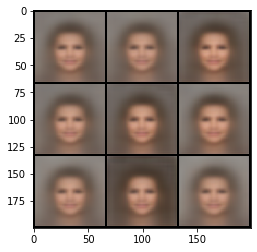

epoch:0, train loss:39253.5234375,recon_loss:38694.765625, kl_loss:5.3772430419921875, valid loss:59226.3384504379


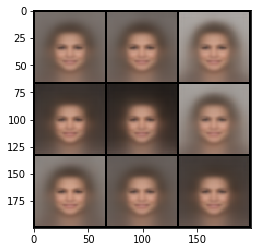

epoch:5, train loss:46353.65625,recon_loss:36059.390625, kl_loss:25.331735610961914, valid loss:49819.96225617038


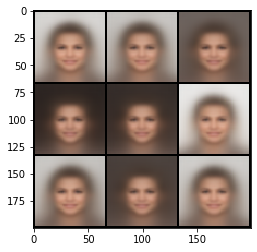

epoch:10, train loss:45474.546875,recon_loss:29471.53125, kl_loss:49.31298828125, valid loss:42751.10708598726


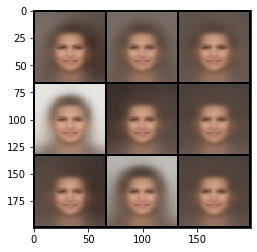

epoch:15, train loss:52301.6171875,recon_loss:29592.099609375, kl_loss:72.29647827148438, valid loss:41306.08203125


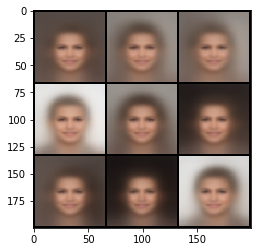

epoch:20, train loss:54167.359375,recon_loss:23189.77734375, kl_loss:93.71841430664062, valid loss:39658.978901273884


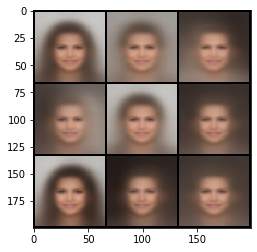

epoch:25, train loss:66675.1875,recon_loss:29142.0234375, kl_loss:116.85283660888672, valid loss:38274.866366441085


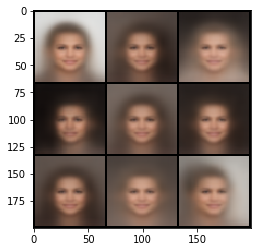

epoch:30, train loss:75735.046875,recon_loss:28837.298828125, kl_loss:137.17825317382812, valid loss:36887.13679339172


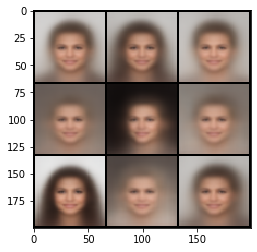

epoch:35, train loss:74872.40625,recon_loss:24911.83203125, kl_loss:150.0394287109375, valid loss:35424.82095939491


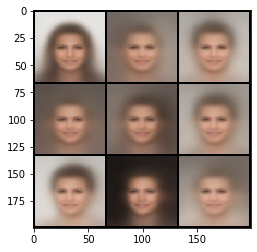

epoch:40, train loss:73687.0,recon_loss:23147.83203125, kl_loss:149.46083068847656, valid loss:35252.85821805334


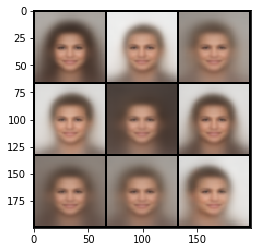

epoch:45, train loss:74327.203125,recon_loss:23387.44140625, kl_loss:149.06024169921875, valid loss:34098.35263236465


In [20]:
for epoch in range(50):
    model.train()
    best_valid = np.inf

    for itr, img in enumerate(train_loader):
        
        img = img.to(device)
        out_img, mu, log_var = model(img)
        
        recon_loss = torch.sum((img-out_img)**2)
        kl_divergence = torch.sum(0.5*(mu**2 + torch.exp(log_var)-log_var-1))
        c = calc_encoding_capacity(epoch*len(train_loader)+itr)
        
        loss = recon_loss + gamma*torch.abs(kl_divergence - c)
        optimizer.zero_grad()                
        loss.backward()
        optimizer.step()
    
    loss_valid = valid_loss(c)
    if epoch%5==0:        
        reconstruct_images(model, img)        
        print('epoch:{}, train loss:{},recon_loss:{}, kl_loss:{}, valid loss:{}'\
              .format(epoch, loss.item(), recon_loss.item(), kl_divergence.item(), loss_valid))
    if loss_valid < best_valid:
        torch.save(model.state_dict(), './saves2/vae_celeba.pth')
        best_valid = loss_valid

In [21]:
model = VAE().to(device)
model.load_state_dict(torch.load('./saves2/vae_celeba.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

- $z_3$ for hair length

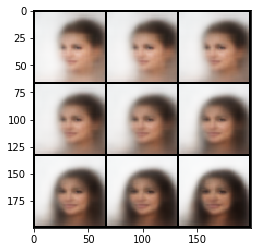

In [38]:
sample_interpolated_images(target_dim=3)

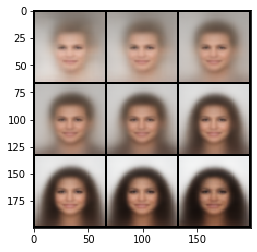

In [41]:
sample_interpolated_images(target_dim=3)

- $z_{6}$ for hair/background

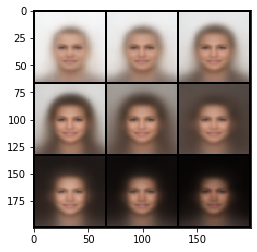

In [61]:
sample_interpolated_images(target_dim=6)

- $z_{43}$ for azimuth

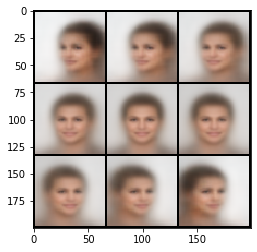

In [72]:
sample_interpolated_images(target_dim=43)

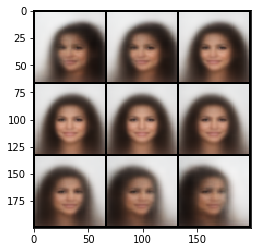

In [84]:
sample_interpolated_images(target_dim=43)